# Analysing our cycling routes

The aim of this notebook is to use data visualization and statistical analysis to obtain deeper insights about the cycling routes in our database, as well as identifying the characteristics of cycling habits in Spain.

Our aim is to answer the following questions:

**1.** Is there a strong correlation between the route variables?<br>
**2.** Do the route values elevation/distance follow a normal distribution? Why/why not?<br>
**3.** Is the geographical distribution of the routes homogeneous?

## Data wrangling: importing and cleaning our dataset

Before we can get our hands on any visualization tools we must import our routes dataset and perform any necessary cleaning and transforming actions in order to obtain an easily-procesed dataframe.

Let's begin by importing our original dataset. It contains all routes in Spain, and since we already cleaned it in the notebook 10 we just need to perform the last step, deleting the useless columns.

In [44]:
#All our library imports will be contained here.

import pandas as pd
import numpy as np
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import statsmodels.api as sm
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.express as px
from pylab import rcParams 
from ipywidgets import interact
import matplotlib.image as mpimg

warnings.simplefilter(action='ignore', category=FutureWarning) #Getting rid of warnings.
rcParams["figure.figsize"] = [12, 8] #Our favourite figure size (or aspect ratio...it's really both).
cf.go_offline()
pd.options.plotting.backend='plotly' #I find Plotly to be a better plotting tool, so I'm setting it as default.

In [36]:
df = pd.read_csv('routes_2807_all.csv')

In [37]:
#Let's check out our dataset.

df.head()

,ID,name,ccaa,province,start,midpoint,trailrank,distance,gradient,min_alt,max_alt,mountain_passes_ids,municipalities_ids,coords,alt,gpx_link
0,1,01-MAY-16 ALMÁCERA-BÉTERA-OLOCAU-GÁTOVA-ALTO D...,NaN,NaN,"(39.510125, -0.355943)","(39.809736, -0.515215)",21,117,1292,0,729,[],NaN,"[(39.510125, -0.355943), (39.510517, -0.35574)...","[-79.616, -79.676, -79.613, -79.208, -79.662, ...",NaN
1,2,"02-AGO-15 Coll de La Gallina, Port de Beixalís...",NaN,NaN,"(42.511074, 1.549479)","(42.532589, 1.561706)",62,93,2850,912,2082,[],NaN,"[(42.511074, 1.549479), (42.511086, 1.549457),...","[1054.713, 1059.043, 1064.307, 1064.808, 1069....",NaN
2,6,07 Goñi-Ultzurrun-Irurzun.,NaN,NaN,"(42.817692, -1.645589)","(42.83568, -1.86435)",28,74,1439,383,870,[],NaN,"[(42.817692, -1.645589), (42.816779, -1.647434...","[456.082, 451.043, 452.017, 446.005, 429.067, ...",NaN
3,9,09-AGO-14 Escaldes - Coll de la Gallina,NaN,NaN,"(42.510941, 1.549156)","(42.462986, 1.44617)",31,38,1150,932,1900,[],NaN,"[(42.510941, 1.549156), (42.511013, 1.54923), ...","[1069.138, 1073.97, 1070.617, 1070.607, 1071.5...",NaN
4,11,12- Lekunberri-Latasa-Beruete-Etxaleku-Saldias...,NaN,NaN,"(43.004854, -1.895447)","(43.058608, -1.763071)",42,74,1681,342,859,"[378, 394]",NaN,"[(43.004854, -1.895447), (43.00503, -1.895352)...","[582.095, 581.849, 572.623, 582.408, 582.621, ...",NaN


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8651 entries, 0 to 8650
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   8651 non-null   int64  
 1   name                 8651 non-null   object 
 2   ccaa                 0 non-null      float64
 3   province             0 non-null      float64
 4   start                8651 non-null   object 
 5   midpoint             8651 non-null   object 
 6   trailrank            8651 non-null   int64  
 7   distance             8651 non-null   int64  
 8   gradient             8651 non-null   int64  
 9   min_alt              8651 non-null   int64  
 10  max_alt              8651 non-null   int64  
 11  mountain_passes_ids  8651 non-null   object 
 12  municipalities_ids   0 non-null      float64
 13  coords               8651 non-null   object 
 14  alt                  8651 non-null   object 
 15  gpx_link             0 non-null      f

Most columns don't give information that we can work with. We will delete them.

In [39]:
df = df.drop(['ID', 'name', 'ccaa', 'province', 'trailrank', 'mountain_passes_ids', 'municipalities_ids', 'coords', 'alt', 'gpx_link'], axis=1)

In [40]:
#That's much better.

df.head()

,start,midpoint,distance,gradient,min_alt,max_alt
0,"(39.510125, -0.355943)","(39.809736, -0.515215)",117,1292,0,729
1,"(42.511074, 1.549479)","(42.532589, 1.561706)",93,2850,912,2082
2,"(42.817692, -1.645589)","(42.83568, -1.86435)",74,1439,383,870
3,"(42.510941, 1.549156)","(42.462986, 1.44617)",38,1150,932,1900
4,"(43.004854, -1.895447)","(43.058608, -1.763071)",74,1681,342,859


# Data visualization

We will be using a selection of libraries to easily visualize the distribution and attributes of our data. But before we begin let's take a quick look at our dataset using some *data exploration* commands.

In [41]:
#Visualizing the distribution of our values.

df.describe()

,distance,gradient,min_alt,max_alt
count,8651.000000,8651.000000,8651.000000,8651.000000
mean,91.407121,1573.662467,360.594267,1032.650676
std,36.577542,828.781101,335.222069,505.966932
min,31.000000,0.000000,0.000000,0.000000
25%,63.000000,981.500000,34.000000,670.000000
50%,88.000000,1435.000000,305.000000,997.000000
75%,113.000000,2032.500000,621.000000,1356.000000
max,229.000000,4692.000000,2542.000000,4449.000000


<AxesSubplot:>

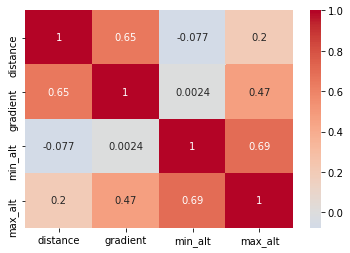

In [42]:
#Displaying the correlation matrix as a heatmap using Seaborn.

sns.heatmap(df.corr(), center=0, cmap='coolwarm', annot=True)



These two commands can already tell us a lot about our data and allow us to answer the **first question**. The correlation is the strongest between minimum and maximum altitudes (**0.69**), probably because routes that start at a higher altitude tend to reach greater heights.

The correlation between distance and gradient is also quite strong (**0.65**), but that was to be expected. As a route gets longer, the rider will have to manage bigger and bigger gradient increases.

We can already answer the first question. Yes, some variables present a strong correlation for the abovementioned reasons.

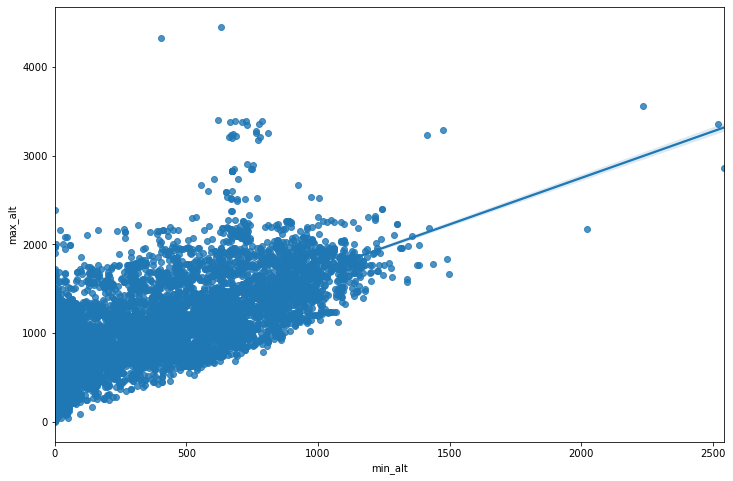

In [50]:
#Visualizing the correlation between minimum and maximum altitude.

_ = sns.regplot(data=df, x='min_alt', y='max_alt')

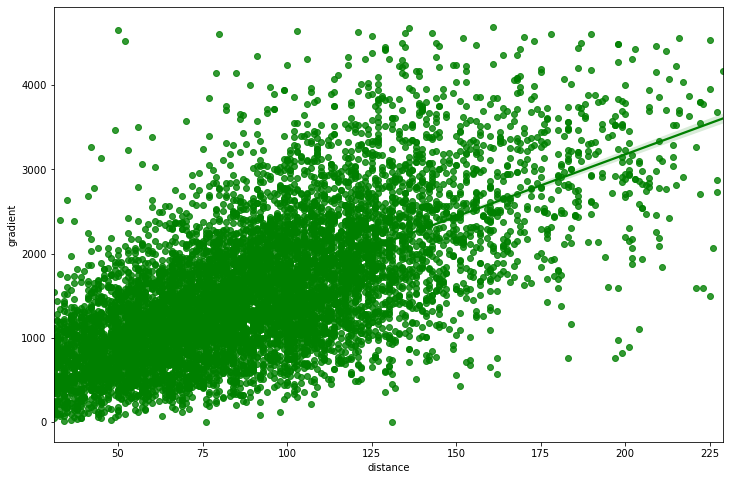

In [53]:
#Visualizing the correlation between distance and gradient.

_ = sns.regplot(data=df, x='distance', y='gradient', color='green')

While there's a relationship between the two in both cases, it's definitely not the strongest. Let's use **Plotly** to add interactivity to our plots and more easily visualize the relationship between distance and gradient.

In [54]:
_ = df.iplot(kind='scatter', x='distance', y='gradient', mode='markers')

## Distribution of the variables

To answer the second question we will be using some data visualization libraries of our choice. We begin with the distribution of the route distances.

In [45]:
#Histogram using Plotly.

df['distance'].hist(title="Distance")

The distribution is far from normal, with a long tail and is quite skewed to the right. This means that while most routes fall into a limited distance range (30-130Km), some riders go for extreme distances. Routes over 200Km could be classified as outliers.

In [56]:
#Histogram of the gradient distribution..

df['gradient'].hist(title="Gradient")

The gradient distribution seems quite similar to the one we've seen before, there's quite a few small but important differences.

**1.** While the distribution of the distance fell very abruplty to the left, the gradient has a much gentler slope (no pun intended). This means that really short routes (<50Km) are very uncommon or don't get uploaded to the platform, while routes with very little elevation do. That's to be expected since it's quite easy to make a long ride with little elevation if you're on flat ground, but not the other way around.
<br>
<br>
**2.** The distribution past the median is pratically identical to the previous one, which gives weight to the high correlation between the two as found in the previous cells.

<div align="right">Ironhack DA PT 2021</div>
    
<div align="right">Xavier Esteban</div>